# CIR Model to simulate changes in Interest Rates and Liability Hedging
The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an exentsion of the popular Vasicek Model to prevent negative interest rates:

$$ dr_t = a(b - r_t) dt + \sigma \sqrt{r_t} dW_t $$

## Short Rate vs Annualized

In [2]:
1 + 1*1

2

In [3]:
1 + 1*.5 + (1 + 1*.5)*.5

2.25

In [4]:
1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25)*.25

2.44140625

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$ \left(1+\frac{r}{N}\right)^N $$

In [6]:
(1 + 1/2)**2

2.25

In [5]:
(1 + 1/4)**4

2.44140625

In [8]:
(1 + 1/100)**100

2.7048138294215285

In [10]:
(1 + 1/10000)**10000

2.7181459268249255

As N becomes very large we get the generalization:

$$ 1+r_{annual} = e^{r_{inst}} $$

i.e.

$$ r_{annual} = e^{r_{inst}} - 1 $$

and 

$$ r_{inst} = ln(1 + r_{annual}) $$

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import math

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized rate to a short rate
    """
    return np.log1p(r)


$$ dr_t = a(b - r_t) dt + \sigma \sqrt{r_t} dW_t $$

In [13]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1 / steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(loc=0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
    
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

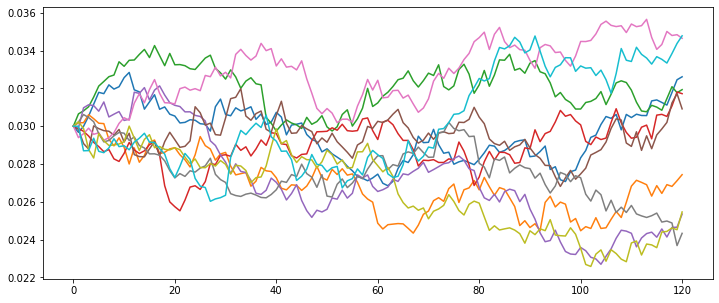

In [16]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$ P(t, T) = A(t, T)e^{-B(t, T) r_{t}}\! $$

where

$$ A(t, T)=\left({\frac {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t, T)=\frac {2(e^{\tau h}-1)}{{2h+(a+h)(e^{\tau h}-1)}} $$
and 
$$ h={\sqrt {a^{2}+2\sigma ^{2}}} $$
and 
$$ \tau = T-t $$

In [19]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest raet evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1 / steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(loc=0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    # For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

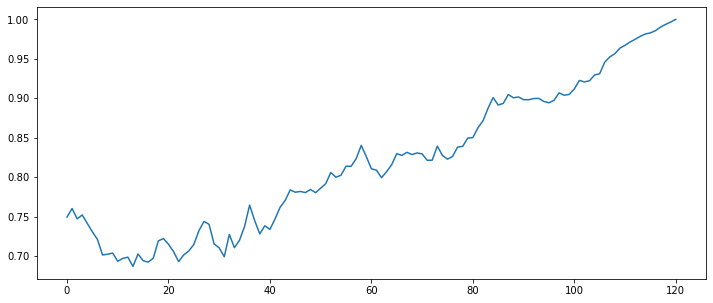

In [21]:
cir(n_scenarios=1)[1].plot(legend=False, figsize=(12,5))

In [24]:
a_0 = .75
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(1+rates/12).cumprod()

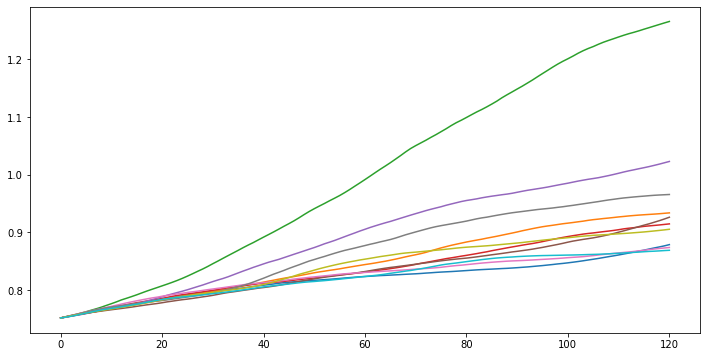

In [26]:
av_cash.plot(legend=False, figsize=(12,6))

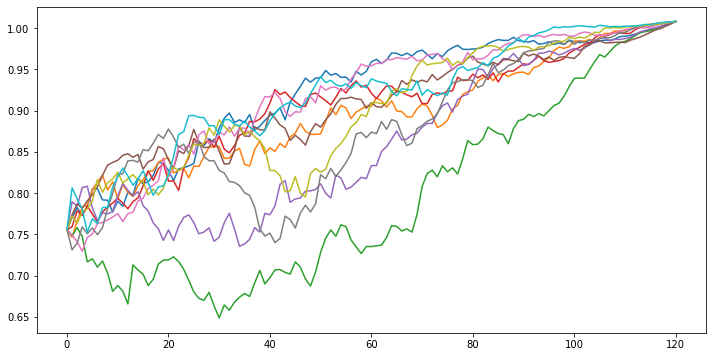

In [27]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

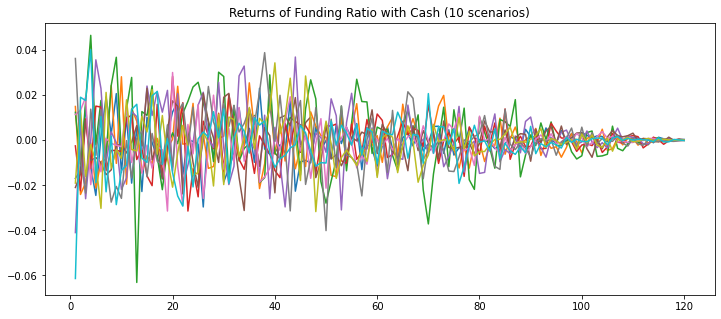

In [28]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

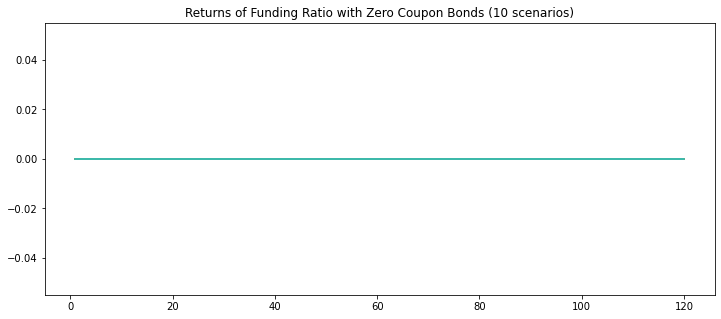

In [30]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Zero Coupon Bonds (10 scenarios)', legend=False, figsize=(12,5))

In [45]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(1 + rates/12).cumprod()

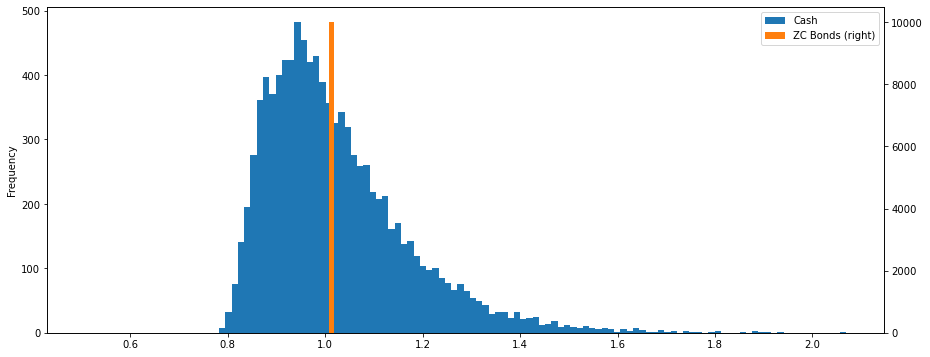

In [46]:
tfr_cash = av_cash.iloc[-1] / liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1] / liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label='Cash', figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label='ZC Bonds', bins=100, legend=True, secondary_y=True)